## Excercise 2: High conductance state

Given the expression for a CUBA LIF neuron:
\begin{align}
	u(t) &= E_l + \frac{I^{\text{ext}}}{g_l} + \sum_{\text{syn }k} \sum_{\text{spk }s} \frac{\tau_k^{\text{syn}}w_k}{g_l(\tau_k^{\text{syn}} - \tau_m)} \Theta(t-t_s) \left[\exp{\left(-\frac{t-t_s}{\tau_k^{\text{syn}}}\right)} - \exp{\left(-\frac{t-t_s}{\tau_m}\right)}\right]
\end{align}
We perform the following replacements:
\begin{align}
	g_l &\rightarrow \langle g^{\text{tot}} \rangle \\
	\tau_m &\rightarrow \langle \tau_{\text{eff}} \rangle \\
	w_k &\rightarrow w_k(E_k^{\text{rev}}-\langle u_{\text{eff}}\rangle)
\end{align}
We get for the shape of a single PSP:
\begin{equation}
	\text{PSP}(t) = \frac{ \tau_k^{\text{syn}} w_k (E_k^{\text{rev}} - \langle u_{\text{eff}} \rangle)}{\langle g^{\text{tot}} \rangle (\tau_k^{\text{syn}} - \langle \tau_{\text{eff}}\rangle)} \Theta(t-t_s) \left[ \exp{\left(-\frac{t-t_s}{\tau_k^{\text{syn}}}\right)} - \exp{\left(-\frac{t-t_s}{\langle \tau_{\text{eff}} \rangle}\right)}\right]
\end{equation}
In order to obtain a closed-form solution for $\langle u_{\text{eff}}\rangle$ we consider the mean value of the total conductance. For exponential synapses the interaction kernel is given by:
\begin{equation}
	\kappa(t) = w_k \Theta(t) \exp{\left(-\frac{t}{\tau_k^{\text{syn}}}\right)}
\end{equation}
With the equations for the first moment of an additive Poisson process we get:
\begin{align}
	E[g^{\text{tot}}]  &= \sum_{k=1}^n \nu_k \int_0^\infty w_k \Theta(t) \exp{\left(-\frac{t}{\tau_k^{\text{syn}}}\right)}dt \\
                        &= \sum_{k=1}^n w_k \nu_k \tau_k^{\text{syn}}
\end{align}
Now we are able to derive an expression for $\langle u_{\text{eff}} \rangle$:
\begin{equation}
	E[u_{\text{eff}}] =  \frac{g_lE_l + I^{\text{ext}} + \sum_k w_k\nu_k\tau_k^{\text{syn}}E_k^{\text{rev}}}{g_l + \sum_k w_k\nu_k\tau_k^{\text{syn}}}
\end{equation}
The membrane potential time course of a COBA LIF neuron is given by:
\begin{equation}
	u(t) = u_{\text{eff}}^0 + \sum_{\text{syn }k} \sum_{\text{spk }s} \frac{ \tau_k^{\text{syn}} w_k (E_k^{\text{rev}} - \langle u_{\text{eff}} \rangle)}{\langle g^{\text{tot}} \rangle (\tau_k^{\text{syn}} - \langle \tau_{\text{eff}}\rangle)} \Theta(t-t_s) \left[ \exp{\left(-\frac{t-t_s}{\tau_k^{\text{syn}}}\right)} - \exp{\left(-\frac{t-t_s}{\langle \tau_{\text{eff}} \rangle}\right)}\right]
\end{equation}
with:
\begin{equation}
    u_{\text{eff}}^0 = \frac{g_l}{g^{\text{tot}}}\left(\langle u_{\text{eff}}\rangle - E_l - \frac{I^{\text{ext}}}{g_l}\right)
\end{equation}

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
matplotlib.rcParams['savefig.dpi'] = 200
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
import numpy as np
import pyNN.nest as sim

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


In [3]:
def plot_spiketrain(spikes, *args, **kwargs):
    for t_s in spikes:
        plt.axvline(t_s, *args, **kwargs)

### PyNN Simulation

In [4]:
neuron_parameters={
    'v_rest'     : -50.0,
    'cm'         : 0.1,
    'tau_m'      : 20.0,
    'tau_syn_E'  : 10.0,
    'tau_syn_I'  : 10.0,
    'v_thresh'   : 70.0,
    'e_rev_E'    : 0,
    'e_rev_I'     : -100,
}
weight = 0.01
t_sim = 1000.
rates = np.linspace(10, 5000, 100)
f_sample_i = 0
dt = 0.1
t = np.arange(0,t_sim,dt)

In [5]:
u_sim = np.zeros((len(rates),len(t)))
t_s_inh = []
t_s_exc = []
for (i,f) in enumerate(rates):
    sim.setup(timestep=dt, min_delay=0.1)
    poisson_exc = sim.Population(1, sim.SpikeSourcePoisson(rate=f, start=0.0, duration=t_sim))
    poisson_inh = sim.Population(1, sim.SpikeSourcePoisson(rate=f, start=0.0, duration=t_sim))
    pop = sim.Population(1, sim.IF_cond_exp(**neuron_parameters))
    pop.record_v()
    poisson_exc.record('spikes')
    poisson_inh.record('spikes')
    sim.Projection(poisson_exc, pop, connector=sim.OneToOneConnector(),
                synapse_type=sim.StaticSynapse(weight=weight),
                receptor_type='excitatory')
    sim.Projection(poisson_inh, pop, connector=sim.OneToOneConnector(),
                synapse_type=sim.StaticSynapse(weight=weight),
                receptor_type='inhibitory')
    sim.run(t_sim)
    u_sim[i] = pop.get_data('v').segments[0].analogsignalarrays[0][:len(t)][:,0]
    t_s_inh.append(poisson_inh.get_data('spikes').segments[0].spiketrains[0])
    t_s_exc.append(poisson_exc.get_data('spikes').segments[0].spiketrains[0])
    sim.end()

/usr/local/nest/lib/python2.7/site-packages/nest/hl_api.py:85: UserWarning: 
ConvergentConnect is deprecated and will be removed in a future version of NEST.
Please use Connect instead!
For details, see http://www.nest-simulator.org/connection_management                       


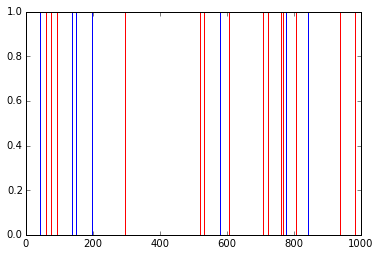

In [6]:
plot_spiketrain(t_s_inh[f_sample_i], c='r')
plot_spiketrain(t_s_exc[f_sample_i], c='b')

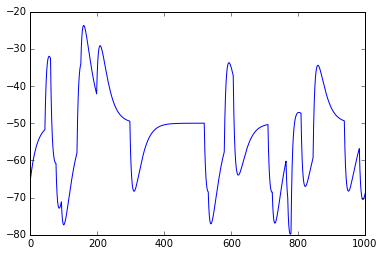

In [7]:
_ = plt.plot(t, u_sim[f_sample_i])

### High Conductance Approximation Model

In [8]:
from numpy import exp

I_ext = 0
E_l = neuron_parameters['v_rest']
C_m = neuron_parameters['cm']
g_l = C_m / neuron_parameters['tau_m']
tau_syn = {
    'inh' : neuron_parameters['tau_syn_I'],
    'exc' : neuron_parameters['tau_syn_E']
}
E_rev = {
    'inh' : neuron_parameters['e_rev_I'],
    'exc' : neuron_parameters['e_rev_E']
}
t_s = {
    'inh' : t_s_inh,
    'exc' : t_s_exc
}

u_eff = lambda f: (g_l*E_l + I_ext + (tau_syn['inh']*E_rev['inh'] + tau_syn['exc']*E_rev['exc'])*weight*f) / (g_l + weight*f*(tau_syn['inh'] + tau_syn['exc']))
g_tot = lambda f: g_l + weight*f/100*(tau_syn['inh'] + tau_syn['exc'])#g_l + C_m/tau_syn['inh'] + C_m/tau_syn['exc']
tau_eff = lambda f: C_m / g_tot(f)
u_eff_0 = lambda f: g_l/g_tot(f)*(u_eff(f)-E_l-I_ext/g_l)
heaviside = lambda t: 0.5 * (np.sign(t) + 1)

In [9]:
g_tot(rates[f_sample_i]), weight*rates[f_sample_i]*(tau_syn['inh'] + tau_syn['exc']), g_l + C_m/tau_syn['inh'] + C_m/tau_syn['exc']

(0.025000000000000001, 2.0, 0.025)

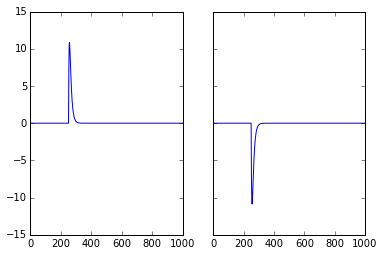

In [10]:
u_spike = lambda t, t_s, syn_type, f: tau_syn[syn_type]*weight*(E_rev[syn_type] - u_eff(f)) / (g_tot(f) * (tau_syn[syn_type] - tau_eff(f))) * heaviside(t-t_s) * ( exp(-(t-t_s)/tau_syn[syn_type]) - exp(-(t-t_s)/tau_eff(f)) )

t_s_sample = t_sim / 4
fig, axs = plt.subplots(1,2, sharey=True)
axs[0].plot(t, u_spike(t, t_s_sample, 'exc', rates[f_sample_i]))
axs[1].plot(t, u_spike(t, t_s_sample, 'inh', rates[f_sample_i]))

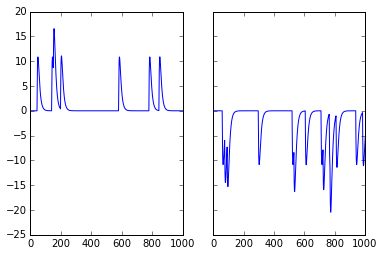

In [11]:
u_syn = lambda t, syn_type, f_i: np.sum(u_spike(*np.meshgrid(t, np.array(t_s[syn_type][f_i])), syn_type=syn_type, f=rates[f_i]), axis=0)

fig, axs = plt.subplots(1,2, sharey=True)
axs[0].plot(t, u_syn(t,'exc', f_sample_i))
axs[1].plot(t, u_syn(t,'inh', f_sample_i))

/Users/knl/.virtualenvs/bic/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
/Users/knl/.virtualenvs/bic/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in multiply


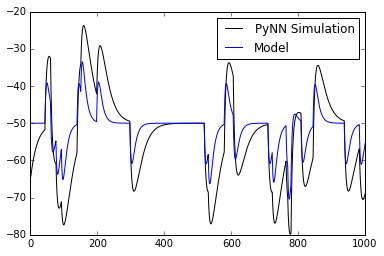

In [12]:
u = lambda t, f_i: u_eff_0(rates[f_i]) + u_syn(t, 'inh', f_i) + u_syn(t, 'exc', f_i)

u_model = np.array([u(t, f_i) for f_i in range(len(rates))]) + E_l

plt.plot(t, u_sim[f_sample_i], c='black', label='PyNN Simulation')
plt.plot(t, u_model[f_sample_i], c='blue', label='Model')
plt.legend()

### Comparison

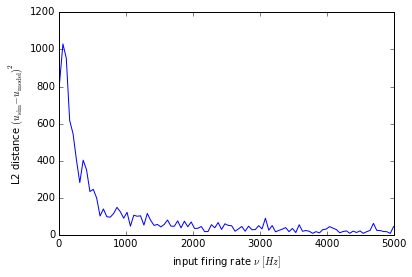

In [13]:
d = [np.sqrt(np.nansum((u_sim[f_i] - u_model[f_i])**2)) for f_i in range(len(rates))]
plt.plot(rates,d)
plt.xlabel(ur'input firing rate $\nu \, [Hz]$')
plt.ylabel(ur'L2 distance $(u_{\mathrm{sim}} - u_{\mathrm{model}})^2$')

The HC approximation is very good for high input rates. We also expect it to yield good results for very low input rates, which the plot above also hints at.